In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt 
import scipy
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

sys.path.append(os.path.abspath('..'))
from xenium_cluster import XeniumCluster

In [2]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"../../../xenium/data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    clustering.xenium_spot_data.X = clustering.xenium_spot_data.X.A
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]
    clustering.xenium_spot_data.obs.rename(columns={"array_row": "row", "array_col": "col"}, inplace=True)

    return data, spatial_locations, clustering

In [3]:
# Data Properties
batch_size = 256
data_dimension = 5
num_clusters = 7
learn_global_variances = False

In [4]:
gene_data, spatial_locations, original_adata = prepare_DLPFC_data(151673)
prior_means = torch.zeros(num_clusters, gene_data.shape[1])
prior_scales = torch.ones(num_clusters, gene_data.shape[1])

In [5]:
original_adata.xenium_spot_data.obs["Region"]

AAACAAGTATCTCCCA-1    Layer3
AAACAATCTACTAGCA-1    Layer1
AAACACCAATAACTGC-1        WM
AAACAGAGCGACTCCT-1    Layer3
AAACAGCTTTCAGAAG-1    Layer5
                       ...  
TTGTTTCACATCCAGG-1        WM
TTGTTTCATTAGTCTA-1        WM
TTGTTTCCATACAACT-1    Layer6
TTGTTTGTATTACACG-1        WM
TTGTTTGTGTAAATTC-1    Layer2
Name: Region, Length: 3639, dtype: category
Categories (7, object): ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM']

/tmp/ipykernel_3126468/3209538980.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_grid[rows, columns] = torch.tensor(original_adata.xenium_spot_data.obs["Region"].cat.codes.values.astype(int)) + 1
/tmp/ipykernel_3126468/3209538980.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters + 1)


Text(0.5, 1.0, 'Ground Truth Regions of DLPFC')

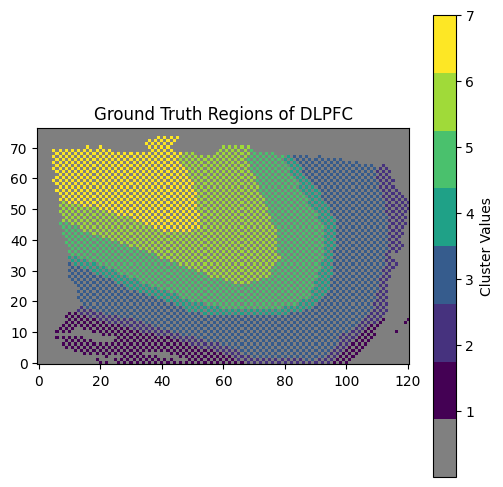

In [6]:
rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = torch.tensor(original_adata.xenium_spot_data.obs["Region"].cat.codes.values.astype(int)) + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)
# Creating a medium gray color for the background
grey_color = [0.5, 0.5, 0.5, 1]  # RGB values for medium gray with full opacity
colormap_colors = np.vstack((grey_color, colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
plt.title('Ground Truth Regions of DLPFC')

/tmp/ipykernel_3126468/2361898019.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters + 1)


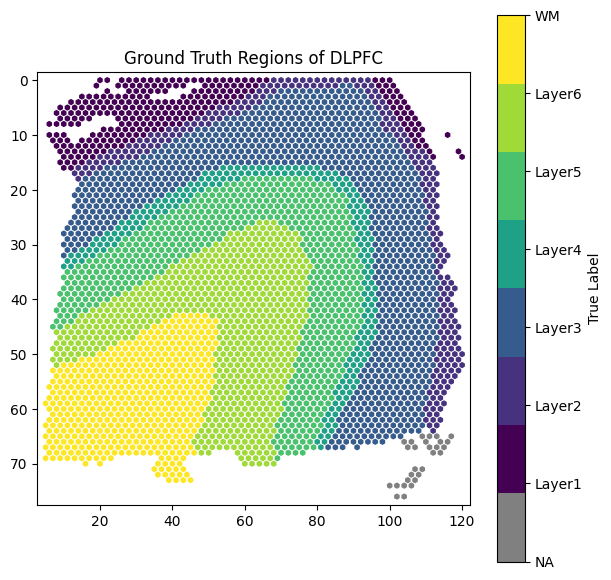

In [7]:
# Extract spatial locations
rows = spatial_locations["row"].astype(float)
columns = spatial_locations["col"].astype(float)

# Create a square figure
plt.figure(figsize=(6, 6))  # Keep the figure square

# Cluster assignments and colormap
# Create mapping between region names and integer codes
region_to_int = {name: code + 1 for code, name in enumerate(original_adata.xenium_spot_data.obs["Region"].cat.categories)}
int_to_region = {code + 1: name for code, name in enumerate(original_adata.xenium_spot_data.obs["Region"].cat.categories)}
# Get cluster assignments using the mapping
cluster_assignments = original_adata.xenium_spot_data.obs["Region"].cat.codes.values.astype(int) + 1
colors = plt.cm.get_cmap('viridis', num_clusters + 1)
grey_color = [0.5, 0.5, 0.5, 1]  # Medium gray for unused cluster
colormap_colors = np.vstack((grey_color, colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

# Scatter plot
plt.scatter(columns, rows, c=cluster_assignments, cmap=colormap, marker='h', s=12)#, edgecolors='white')

# Calculate padding for the axis limits
x_padding = (columns.max() - columns.min()) * 0.02  # 2% padding
y_padding = (rows.max() - rows.min()) * 0.02        # 2% padding

# Set axis limits with padding
plt.xlim(columns.min() - x_padding, columns.max() + x_padding)
plt.ylim(rows.min() - y_padding, rows.max() + y_padding)

# Force square appearance by stretching the y-axis
plt.gca().set_aspect((columns.max() - columns.min() + 2 * x_padding) / 
                     (rows.max() - rows.min() + 2 * y_padding))  # Adjust for padded ranges
plt.gca().invert_yaxis()  # Maintain spatial orientation
plt.tight_layout()  # Minimize padding around the plot

# Add colorbar and title
plt.colorbar(ticks=range(num_clusters + 1), label="True Label").set_ticklabels(["NA"] + list(int_to_region.values()))
plt.title('Ground Truth Regions of DLPFC')

plt.savefig("ground_truth_DLPFC.png")
plt.show()


In [8]:
original_adata.xenium_spot_data.obsm["X_pca"].std(axis=0)

array([12.4453335,  4.9366527,  2.0713081,  1.8259656,  1.5240269],
      dtype=float32)

/home/roko/diff/nf/xenium_cluster.py:494: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(data.obs["row"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cols = torch.tensor(data.obs["col"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:496: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clusters = torch.tensor(data.obs["cluster"].astype(int))
/home/roko/diff/n

array([5, 2, 4, ..., 2, 4, 6], dtype=int32)

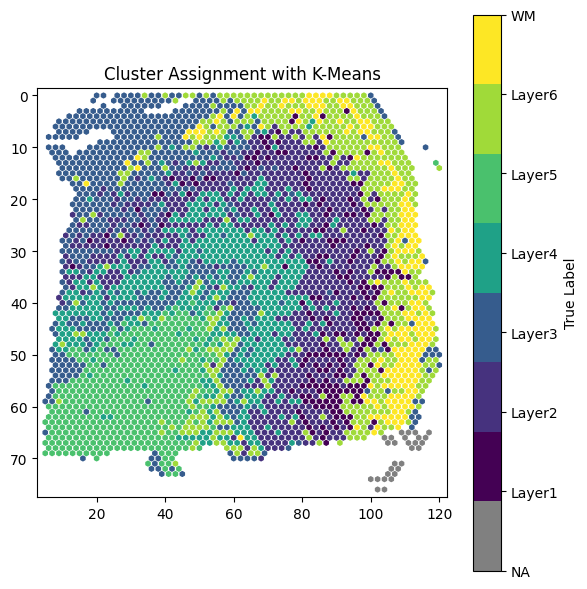

In [9]:
original_adata.KMeans(original_adata.xenium_spot_data, K=7, include_spatial=False, use_pca=True)

/home/roko/diff/nf/xenium_cluster.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['5', '6', '1', '2', '2', ..., '1', '1', '1', '1', '0']
Length: 3611
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.obs.loc[non_na_mask, f'leiden_{resolution}'] = masked_data_clusters.obs[f'leiden_{resolution}']
/home/roko/diff/nf/xenium_cluster.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(data.obs["row"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels

{0.175: array([5, 6, 1, ..., 1, 1, 0])}

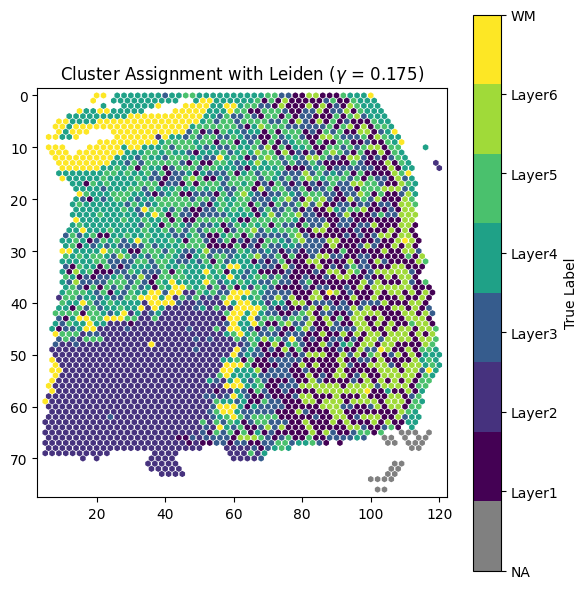

In [11]:
original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, n_neighbors=15, n_pcs=3, plot_pcas=False)
original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.175])

/home/roko/diff/nf/xenium_cluster.py:265: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['5', '6', '0', '1', '1', ..., '0', '0', '0', '0', '2']
Length: 3611
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.obs.loc[non_na_mask, f'louvain_{resolution}'] = masked_data_clusters.obs[f'louvain_{resolution}']
/home/roko/diff/nf/xenium_cluster.py:283: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(data.obs["row"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:284: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

['5' '6' '0' '1' '2' '4' '3' -1]
0.25


{0.25: array([5, 6, 0, ..., 0, 0, 2])}

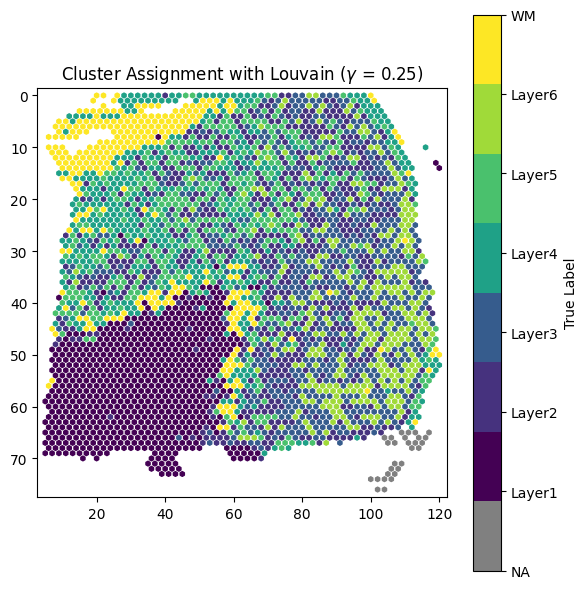

In [12]:
original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[0.25])